## CLOUD-BASED DETECTION USING RASPBERRY PI

The Raspberry Pi (RPi) which is a single board computer is suitable for lots of applications due to its portability and low-cost. With this merit comes some disadvantages like low computational capacity in terms of memory and processing. In this project, the Rpi, a remote computer runing MATLAB and Dropbox API are used to develop a cloud-based detection and recognition system. The multi-class Object Detector (with five classes of objects namely: Mouse, Keyboard, Broom, Television and Fan)was trained with Faster RCNN with ImageNet Dataset. 

## How it Works

***The Raspberry Pi***

The Raspberry pi captures, resize,and upload an image to Dropbox. The image is accompanied with a txt file having a flag of 1.Once the flag reads 2, the RPi will download the image with objects detected and display on its screen. 

In [ ]:
#!/usr/bin/env python3

import time
startTime = time.time()
import picamera
import cv2
import dropbox



## create dropbox object and upload image
dbx = dropbox.Dropbox('xDGQGK6on4AAAAAAAAAA70D_7U95KJEpFt3_AyBdJVRqc-bAbsDKV3-1FGvWVAVs')

def uploadFile(fileFrom, fileTo):
	f = open(fileFrom,"rb")
	dbx.files_upload(f.read(), fileTo, mode = dropbox.files.WriteMode.overwrite)
	f.close()

def downloadFile(fileFrom,fileTo):
	f = open(fileTo,"wb")
	metadata, res = dbx.files_download(path=fileFrom)
	f.write(res.content)




# initialize camera
camera = picamera.PiCamera()
camera.resolution = (2592, 1944)
camera.rotation = 180
camera.start_preview()
time.sleep(5)

#capture and save image
camera.capture('/home/pi/Images/img.jpg')
camera.stop_preview()
print("Image captured")

# Read,Resize and save image in jpg
Image = cv2.imread("/home/pi/Images/img.jpg")
Image = cv2.resize(Image, (400,400))
cv2.imwrite("/home/pi/Images/prepImage.jpg", Image )

# Create and write 1 to a text file
fh = open ('flag_pi.txt', 'w+')
fh.write('1')
fh.close()

# Upload image and textfile to Dropbox
uploadFile("/home/pi/Images/prepImage.jpg", "/capturedImage.jpg")
uploadFile("/home/pi/flag_pi.txt","/flag_pi.txt")
print("Image Uploaded")
time.sleep(30)

# Download textfile and check content

while True:


        downloadFile("/flag_mat.txt","/home/pi/flag_mat.txt")
        with open("/home/pi/flag_mat.txt","r+") as fh:
            value = fh.read()
            print(value)
            fh.close()

# Download result if content is 2

        if value == '2':
            downloadFile("/DetImg.jpg","/home/pi/Images/DetectedImage.jpg")
            print("file downloaded")


            # display output image
            DetImage = cv2.imread("/home/pi/Images/DetectedImage.jpg")
            cv2.imshow("Detected Image", DetImage)
            endTime = time.time()
            print("Execution time: ","{0:.2f}".format(endTime - startTime)+ "Seconds") 
            cv2.waitKey(0)
#cv2.destroyAllWindows()
            dbx.files_delete('/DetImg.jpg')
            dbx.files_delete('/flag_mat.txt')
            fh = open ('flag_pi.txt', 'w+')
            fh.write('2')
            fh.close()
            uploadFile("/home/pi/flag_pi.txt","/flag_pi.txt")
            print("file Uploaded")
            break

        else:
            print('Unable to download file')
            endTime = time.time()
            print("Execution time: ","{0:.2f}".format(endTime - startTime)+ " Seconds")


***The Remote Computer***

On MATLAB running on a remote Computer, the image id dowloaded from Dropbox API, fed into the multiclass detector and uploaded back to Dropbox alongside the flag.txt file with a flag of 2.

In [ ]:
Get Image from dropbox if content of flag_pi.txt is 1
accessToken = ('');
fileNames = {'capturedImage.jpg'};
checkfile = {'flag_pi.txt'};

load('detectorTraining.mat', 'detector');



while 1
    downloadFromDropbox(accessToken,checkfile);
    fileID = fopen('flag_pi.txt', 'rt', 'n');
    %fline = fgetl(fileID);
    formatSpec = '%d';
    value = fscanf(fileID, formatSpec);
    fclose(fileID);
    matFileID = fopen('flag_mat.txt', 'wt','n');
    fprintf(matFileID, formatSpec, (2));
    fclose(matFileID);
       
    if value == 1
        downloadFromDropbox(accessToken, fileNames);
        
        break
    
    end
end

%% Run the detector on the acquired Image
D = imread('capturedImage.jpg');
[bboxes, scores, labels] = detect(detector, D);

Save resulting BBoxes, Scores and Labels
%fid = fopen('Output.txt', 'w');
%fprintf(fid, '%f\n' , bboxes);
%fprintf(fid, '%f\n', scores);
%fprintf(fid, '%s', labels);



Insert the Annotations
DetectedImg = insertObjectAnnotation(D,'rectangle',bboxes,cellstr(labels));
Img = insertObjectAnnotation(D,'rectangle',bboxes,scores);
imwrite(DetectedImg, 'DetImg.jpg');

Upload Result to Dropbox
uploadToDropbox(accessToken, 'flag_mat.txt');
uploadToDropbox(accessToken,'DetImg.jpg')
figure
imshow(DetectedImg)
imshow(Img)



***Detected Object Images***

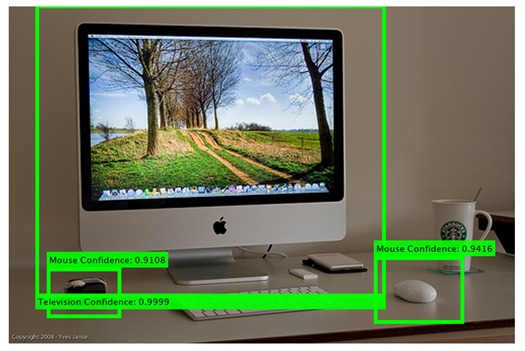

Fig 1


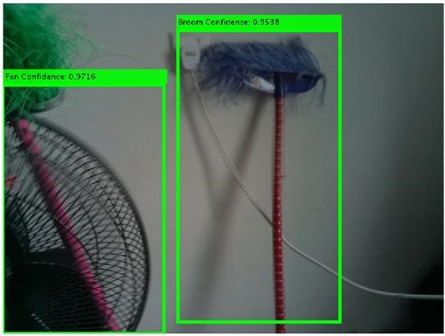

Fig 2

Fig 1 and 2 are examples of the detector output. Fig shows the output while evaluating the detector with test images from ImageNet while Fig 2 is the result of the entire process in real-time (From image capturing to Display on the RPi)